In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Install mlcroissant if not installed
try:
    import mlcroissant
except ImportError:
    %pip install mlcroissant

import mlcroissant as mlc

# Load dataset using Croissant from Kaggle

In [11]:
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/mnassrib/jena-climate/croissant/download')
record_sets = croissant_dataset.metadata.record_sets

  -  [Metadata(Jena Climate Dataset)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(Jena Climate Dataset)] Property "https://schema.org/version" is recommended, but does not exist.


# Load records into DataFrame

In [12]:
df = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))
print("Loaded DataFrame Columns:", df.columns)

Loaded DataFrame Columns: Index(['jena_climate_2009_2016.csv/Date+Time',
       'jena_climate_2009_2016.csv/p+(mbar)',
       'jena_climate_2009_2016.csv/T+(degC)',
       'jena_climate_2009_2016.csv/Tpot+(K)',
       'jena_climate_2009_2016.csv/Tdew+(degC)',
       'jena_climate_2009_2016.csv/rh+(%25)',
       'jena_climate_2009_2016.csv/VPmax+(mbar)',
       'jena_climate_2009_2016.csv/VPact+(mbar)',
       'jena_climate_2009_2016.csv/VPdef+(mbar)',
       'jena_climate_2009_2016.csv/sh+(g%2Fkg)',
       'jena_climate_2009_2016.csv/H2OC+(mmol%2Fmol)',
       'jena_climate_2009_2016.csv/rho+(g%2Fm**3)',
       'jena_climate_2009_2016.csv/wv+(m%2Fs)',
       'jena_climate_2009_2016.csv/max.+wv+(m%2Fs)',
       'jena_climate_2009_2016.csv/wd+(deg)'],
      dtype='object')


# Use the temperature column for forecasting

In [14]:
temps = df["jena_climate_2009_2016.csv/T+(degC)"].astype(np.float32).values

# Normalize

In [15]:
mean = temps.mean()
std = temps.std()
temps = (temps - mean) / std

# Create input-output pairs

In [16]:
def create_dataset(series, input_len=24, pred_len=1):
    X, y = [], []
    for i in range(len(series) - input_len - pred_len):
        X.append(series[i:i+input_len])
        y.append(series[i+input_len:i+input_len+pred_len])
    return np.array(X), np.array(y)

X, y = create_dataset(temps, input_len=24)
X = X[..., np.newaxis]  # Add channel dimension

# Train-test split

In [17]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(24, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# Compile and train

In [19]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - loss: 0.0090 - val_loss: 6.3079e-04
Epoch 2/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 6.2096e-04 - val_loss: 6.3321e-04
Epoch 3/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 6.0187e-04 - val_loss: 6.3120e-04
Epoch 4/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - loss: 5.9390e-04 - val_loss: 6.0863e-04
Epoch 5/5
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 90s 11ms/step - loss: 5.8928e-04 - val_loss: 6.3224e-04


# Predict

In [20]:
preds = model.predict(X_test[:100]).flatten()
true = y_test[:100].flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


# Plot results

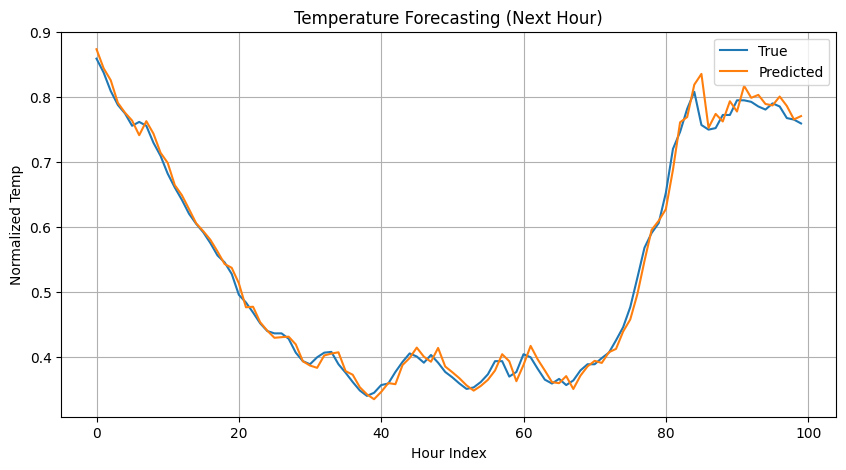

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(true, label="True")
plt.plot(preds, label="Predicted")
plt.title("Temperature Forecasting (Next Hour)")
plt.xlabel("Hour Index")
plt.ylabel("Normalized Temp")
plt.legend()
plt.grid(True)
plt.show()